# NLP-based Data Science - Comparison of machine learning models using the example of text classification of twitter data

## Introduction
The following Notebook shows the capability of machine learning models on text data. This notebook specifically shows the evaluation of the machine learning models without standard scaler and no additional features. The image below shows which results of the overall result table are evaluated in this notebook.

## 1. Imports

In [1]:
import re
import string
import nltk
import Emoticons
import Chatwords
import textstat

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.inter_rater import fleiss_kappa

from sklearn_pandas import DataFrameMapper

from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker

from textblob import TextBlob

from tqdm.auto import tqdm 
#import cudf

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Loading the data and preparing the dataframe for further analysis 

### 2.1 Loading the Data

In [2]:
df = pd.read_csv("labeled_data.csv")
#df_test_data = pd.read_excel("Covid_tweet_data_for_annotation.xlsx")
df.drop(columns=["Unnamed: 0"], inplace = True)
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


### 2.2 Grouping offensive language + hatespeech
The original paper where this dataset is from categorizes all tweets in the three classes "normal", "offensive language" and "hate speech". Since hate speech has lots of different definitions it is very difficult even for humans to clearly determine whether a tweet should be labeled as hate speech or not. Therefore this project will focus on the detection of offensive language in general. To be able to use the whole dataset I will group all tweets in this dataset labeled as "offensive language" or "hate speech" together and give it the class "Offensive language+".

In [3]:
df["grouped_class_descr"] = df["class"].apply(lambda x: "Offensive language+" if x == 0 or x == 1 else "Normal")
df["grouped_class"] = df["class"].apply(lambda x: 1 if x == 0 or x == 1 else 0)

print(df["grouped_class"].value_counts())
print("-"*40)
print(df["grouped_class_descr"].value_counts())
df.head()

1    20620
0     4163
Name: grouped_class, dtype: int64
----------------------------------------
Offensive language+    20620
Normal                  4163
Name: grouped_class_descr, dtype: int64


,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,Normal,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive language+,1
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive language+,1
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive language+,1
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive language+,1


## 3. Data preprocessing
In this step I am going to preprocess the raw tweets in order to make the data more uniformly and therefore easier to process by machine learning models. <br><br>I will apply the following preprocessing steps in the following order:
1. Making all words lowercase
2. Cleaning the tweets --> removing mentions, hashtags, urls and retweets
3. Converting Emoticons to text
4. Removing all newlines (\n)
5. Converting all chat words to full words
6. Removing all digits
7. Removing punctuation 
8. Spelling correction
9. Removing stopwords
10. WordNetLemmatizer to group words together to it's basic form



I choose this order of preprocessing steps for several reasons. For step two & three the tweet has to be in raw format in order to work properly. For example urls can only be removed if no characters of the url are deleted. After step three things like newlines and digits will be removed. It is important that the chatword conversion will be done before the removal of digits and punctuation because chatwords include digits and special characters which will be removed after step six and seven. The next step after the removal of punctuation is the spelling correction. In this case it makes sense to do the spelling correction before the stopword removal because some words might be corrected to a stop word in the process of spelling correction. After step eight and nine the last step in the preprocessing chain will be the use of the wordnetlemmatizer. It is important to do this step at the end of the preprocessing chain because it might benefit from earlier steps like the spelling correction. 

### 3.1 Converting all words to lowercase

In [4]:
df["tweet"] = df["tweet"].str.lower()
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class
0,3,0,0,3,2,!!! rt @mayasolovely: as a woman you shouldn't...,Normal,0
1,3,0,3,0,1,!!!!! rt @mleew17: boy dats cold...tyga dwn ba...,Offensive language+,1
2,3,0,3,0,1,!!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...,Offensive language+,1
3,3,0,2,1,1,!!!!!!!!! rt @c_g_anderson: @viva_based she lo...,Offensive language+,1
4,6,0,6,0,1,!!!!!!!!!!!!! rt @shenikaroberts: the shit you...,Offensive language+,1
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@t_madison_x: the shit just...",Offensive language+,1
6,3,0,3,0,1,"!!!!!!""@__brighterdays: i can not just sit up ...",Offensive language+,1
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause i'm tired of...,Offensive language+,1
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",Offensive language+,1
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting maria...",Offensive language+,1


### 3.2 Basic text cleaning
**Removing:**
- Mentions
- Hashtags
- Retweets
- URL`s

In [5]:
# Get all the deleted characters and word
def get_deleted_text(text):
    """Custom function to get the delted text which is deleted using the clean_text function"""
    return {
        "removed mentions": re.findall('@[A-Za-z0-9]+',text), # getting mentions
        "removed hashtags": re.findall('#',text), # getting hashtags
        "removed retweets": re.findall('RT[\s]+',text), # getting retweets
        "removed urls": re.findall('https?:\/\/\S+',text) # getting urls
    }

# Delete all mentions, hashtags, urls and retweets
def clean_text(text):
    """Custom function to delete mentions, hashtags, urls and retweets"""
    text= re.sub('@[A-Za-z0-9]+','',text ) # removing mentions
    text= re.sub("#",'',text) # removing hashtags
    text= re.sub('rt[\s]+','',text) # removing retweets
    text= re.sub('https?:\/\/\S+','',text) # removing urls
    return text

df["deleted_text"] = df["tweet"].apply(get_deleted_text)
df["tweet"] = df["tweet"].apply(clean_text)
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text
0,3,0,0,3,2,!!! : as a woman you shouldn't complain about ...,Normal,0,"{'removed mentions': ['@mayasolovely'], 'remov..."
1,3,0,3,0,1,!!!!! : boy dats cold...tyga dwn bad for cuffi...,Offensive language+,1,"{'removed mentions': ['@mleew17'], 'removed ha..."
2,3,0,3,0,1,!!!!!!! dawg!!!! : you ever fuck a bitch and s...,Offensive language+,1,"{'removed mentions': ['@urkindofbrand', '@80sb..."
3,3,0,2,1,1,!!!!!!!!! _g_anderson: _based she look like a ...,Offensive language+,1,"{'removed mentions': ['@c', '@viva'], 'removed..."
4,6,0,6,0,1,!!!!!!!!!!!!! : the shit you hear about me mig...,Offensive language+,1,"{'removed mentions': ['@shenikaroberts'], 'rem..."
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""_madison_x: the shit just b...",Offensive language+,1,"{'removed mentions': ['@t'], 'removed hashtags..."
6,3,0,3,0,1,"!!!!!!""@__brighterdays: i can not just sit up ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
7,3,0,3,0,1,!!!!&8220;: cause i'm tired of you big bitches...,Offensive language+,1,"{'removed mentions': ['@selfiequeenbri'], 'rem..."
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
9,3,1,2,0,1,""" _ :hobbies include: fighting mariam""\n\nbitch",Offensive language+,1,"{'removed mentions': ['@rhythmixx'], 'removed ..."


### 3.3 Conversion of Emoticons to text

In [6]:
# source: https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py

EMOTICONS = Emoticons.EMOTICONS

def convert_emoticons(text):
    """Custom function to convert Emoticons to text"""
    for emot in EMOTICONS.keys():
        emot_modified = f" {emot} "
        #print(emot_modified, len(emot_modified))
        text = re.sub(emot_modified, " " + " ".join(EMOTICONS[emot].replace(",","").split()).lower() + " ", text)
    return text

df["tweet"] = df["tweet"].apply(convert_emoticons)
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text
0,3,0,0,3,2,!!! : as a woman you shouldn't complain about ...,Normal,0,"{'removed mentions': ['@mayasolovely'], 'remov..."
1,3,0,3,0,1,!!!!! : boy dats cold...tyga dwn bad for cuffi...,Offensive language+,1,"{'removed mentions': ['@mleew17'], 'removed ha..."
2,3,0,3,0,1,!!!!!!! dawg!!!! : you ever fuck a bitch and s...,Offensive language+,1,"{'removed mentions': ['@urkindofbrand', '@80sb..."
3,3,0,2,1,1,!!!!!!!!! _g_anderson: _based she look like a ...,Offensive language+,1,"{'removed mentions': ['@c', '@viva'], 'removed..."
4,6,0,6,0,1,!!!!!!!!!!!!! : the shit you hear about me mig...,Offensive language+,1,"{'removed mentions': ['@shenikaroberts'], 'rem..."
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""_madison_x: the shit just b...",Offensive language+,1,"{'removed mentions': ['@t'], 'removed hashtags..."
6,3,0,3,0,1,"!!!!!!""@__brighterdays: i can not just sit up ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
7,3,0,3,0,1,!!!!&8220;: cause i'm tired of you big bitches...,Offensive language+,1,"{'removed mentions': ['@selfiequeenbri'], 'rem..."
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
9,3,1,2,0,1,""" _ :hobbies include: fighting mariam""\n\nbitch",Offensive language+,1,"{'removed mentions': ['@rhythmixx'], 'removed ..."


### 3.4 Removal of newlines (\n)

In [7]:
def remove_new_lines(text):
    text = re.sub(r"\n", " ", text)
    return text

df["tweet"] = df["tweet"].apply(remove_new_lines)
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text
0,3,0,0,3,2,!!! : as a woman you shouldn't complain about ...,Normal,0,"{'removed mentions': ['@mayasolovely'], 'remov..."
1,3,0,3,0,1,!!!!! : boy dats cold...tyga dwn bad for cuffi...,Offensive language+,1,"{'removed mentions': ['@mleew17'], 'removed ha..."
2,3,0,3,0,1,!!!!!!! dawg!!!! : you ever fuck a bitch and s...,Offensive language+,1,"{'removed mentions': ['@urkindofbrand', '@80sb..."
3,3,0,2,1,1,!!!!!!!!! _g_anderson: _based she look like a ...,Offensive language+,1,"{'removed mentions': ['@c', '@viva'], 'removed..."
4,6,0,6,0,1,!!!!!!!!!!!!! : the shit you hear about me mig...,Offensive language+,1,"{'removed mentions': ['@shenikaroberts'], 'rem..."
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""_madison_x: the shit just b...",Offensive language+,1,"{'removed mentions': ['@t'], 'removed hashtags..."
6,3,0,3,0,1,"!!!!!!""@__brighterdays: i can not just sit up ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
7,3,0,3,0,1,!!!!&8220;: cause i'm tired of you big bitches...,Offensive language+,1,"{'removed mentions': ['@selfiequeenbri'], 'rem..."
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
9,3,1,2,0,1,""" _ :hobbies include: fighting mariam"" bitch",Offensive language+,1,"{'removed mentions': ['@rhythmixx'], 'removed ..."


### 3.5 Conversion of chat words

In [8]:
# Processing the Chat words from Chatwords.py
chat_words_str = Chatwords.chat_words_str
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1].lower()
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)
#print(chat_words_map_dict)

def convert_chat_words(text):
    """Custom function that converts Chatwords into normal words"""
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

df["tweet"] = df["tweet"].apply(convert_chat_words)
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text
0,3,0,0,3,2,!!! : as a woman you shouldn't complain about ...,Normal,0,"{'removed mentions': ['@mayasolovely'], 'remov..."
1,3,0,3,0,1,!!!!! : boy dats cold...tyga dwn bad for cuffi...,Offensive language+,1,"{'removed mentions': ['@mleew17'], 'removed ha..."
2,3,0,3,0,1,!!!!!!! dawg!!!! : you ever fuck a bitch and s...,Offensive language+,1,"{'removed mentions': ['@urkindofbrand', '@80sb..."
3,3,0,2,1,1,!!!!!!!!! _g_anderson: _based she look like a ...,Offensive language+,1,"{'removed mentions': ['@c', '@viva'], 'removed..."
4,6,0,6,0,1,!!!!!!!!!!!!! : the shit you hear about me mig...,Offensive language+,1,"{'removed mentions': ['@shenikaroberts'], 'rem..."
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""_madison_x: the shit just b...",Offensive language+,1,"{'removed mentions': ['@t'], 'removed hashtags..."
6,3,0,3,0,1,"!!!!!!""@__brighterdays: i can not just sit up ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
7,3,0,3,0,1,!!!!&8220;: cause i'm tired of you big bitches...,Offensive language+,1,"{'removed mentions': ['@selfiequeenbri'], 'rem..."
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
9,3,1,2,0,1,""" _ :hobbies include: fighting mariam"" bitch",Offensive language+,1,"{'removed mentions': ['@rhythmixx'], 'removed ..."


### 3.6 Removal of all digits

In [9]:
def remove_digits(text):
    text = re.sub("\d", " ", text)
    return text

df["tweet"] = df["tweet"].apply(remove_digits)
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text
0,3,0,0,3,2,!!! : as a woman you shouldn't complain about ...,Normal,0,"{'removed mentions': ['@mayasolovely'], 'remov..."
1,3,0,3,0,1,!!!!! : boy dats cold...tyga dwn bad for cuffi...,Offensive language+,1,"{'removed mentions': ['@mleew17'], 'removed ha..."
2,3,0,3,0,1,!!!!!!! dawg!!!! : you ever fuck a bitch and s...,Offensive language+,1,"{'removed mentions': ['@urkindofbrand', '@80sb..."
3,3,0,2,1,1,!!!!!!!!! _g_anderson: _based she look like a ...,Offensive language+,1,"{'removed mentions': ['@c', '@viva'], 'removed..."
4,6,0,6,0,1,!!!!!!!!!!!!! : the shit you hear about me mig...,Offensive language+,1,"{'removed mentions': ['@shenikaroberts'], 'rem..."
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""_madison_x: the shit just b...",Offensive language+,1,"{'removed mentions': ['@t'], 'removed hashtags..."
6,3,0,3,0,1,"!!!!!!""@__brighterdays: i can not just sit up ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
7,3,0,3,0,1,!!!!& ;: cause i'm tired of you big bitches...,Offensive language+,1,"{'removed mentions': ['@selfiequeenbri'], 'rem..."
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
9,3,1,2,0,1,""" _ :hobbies include: fighting mariam"" bitch",Offensive language+,1,"{'removed mentions': ['@rhythmixx'], 'removed ..."


### 3.7 Removal of Punctuation
**The following Characters count as punctuation:**
<br>
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

In [10]:
# Remove punctuation
#print(string.punctuation)
def remove_punctuation(text):
    """Custom function to remove punctuation"""
    return text.translate(str.maketrans('', '', string.punctuation))

df["tweet"] = df["tweet"].apply(remove_punctuation)
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text
0,3,0,0,3,2,as a woman you shouldnt complain about clean...,Normal,0,"{'removed mentions': ['@mayasolovely'], 'remov..."
1,3,0,3,0,1,boy dats coldtyga dwn bad for cuffin dat hoe...,Offensive language+,1,"{'removed mentions': ['@mleew17'], 'removed ha..."
2,3,0,3,0,1,dawg you ever fuck a bitch and she stato cry...,Offensive language+,1,"{'removed mentions': ['@urkindofbrand', '@80sb..."
3,3,0,2,1,1,ganderson based she look like a tranny,Offensive language+,1,"{'removed mentions': ['@c', '@viva'], 'removed..."
4,6,0,6,0,1,the shit you hear about me might be true or ...,Offensive language+,1,"{'removed mentions': ['@shenikaroberts'], 'rem..."
5,3,1,2,0,1,madisonx the shit just blows meclaim you so fa...,Offensive language+,1,"{'removed mentions': ['@t'], 'removed hashtags..."
6,3,0,3,0,1,brighterdays i can not just sit up and hate on...,Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
7,3,0,3,0,1,cause im tired of you big bitches coming ...,Offensive language+,1,"{'removed mentions': ['@selfiequeenbri'], 'rem..."
8,3,0,3,0,1,amp you might not get ya bitch back amp thats...,Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
9,3,1,2,0,1,hobbies include fighting mariam bitch,Offensive language+,1,"{'removed mentions': ['@rhythmixx'], 'removed ..."


### 3.8 Spelling correction

In [11]:
"""
tqdm.pandas()
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

df["tweet"] = df["tweet"].progress_apply(correct_spellings)
df.head(25)
"""

'\ntqdm.pandas()\nspell = SpellChecker()\ndef correct_spellings(text):\n    corrected_text = []\n    misspelled_words = spell.unknown(text.split())\n    for word in text.split():\n        if word in misspelled_words:\n            corrected_text.append(spell.correction(word))\n        else:\n            corrected_text.append(word)\n    return " ".join(corrected_text)\n\ndf["tweet"] = df["tweet"].progress_apply(correct_spellings)\ndf.head(25)\n'

### 3.9 Removal of stopwords

In [12]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["tweet"] = df["tweet"].apply(remove_stopwords)
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text
0,3,0,0,3,2,woman shouldnt complain cleaning house amp man...,Normal,0,"{'removed mentions': ['@mayasolovely'], 'remov..."
1,3,0,3,0,1,boy dats coldtyga dwn bad cuffin dat hoe st place,Offensive language+,1,"{'removed mentions': ['@mleew17'], 'removed ha..."
2,3,0,3,0,1,dawg ever fuck bitch stato cry confused shit,Offensive language+,1,"{'removed mentions': ['@urkindofbrand', '@80sb..."
3,3,0,2,1,1,ganderson based look like tranny,Offensive language+,1,"{'removed mentions': ['@c', '@viva'], 'removed..."
4,6,0,6,0,1,shit hear might true might faker bitch told ya,Offensive language+,1,"{'removed mentions': ['@shenikaroberts'], 'rem..."
5,3,1,2,0,1,madisonx shit blows meclaim faithful somebody ...,Offensive language+,1,"{'removed mentions': ['@t'], 'removed hashtags..."
6,3,0,3,0,1,brighterdays sit hate another bitch got much s...,Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
7,3,0,3,0,1,cause im tired big bitches coming us skinny girls,Offensive language+,1,"{'removed mentions': ['@selfiequeenbri'], 'rem..."
8,3,0,3,0,1,amp might get ya bitch back amp thats,Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
9,3,1,2,0,1,hobbies include fighting mariam bitch,Offensive language+,1,"{'removed mentions': ['@rhythmixx'], 'removed ..."


### 3.10 WordNet Lemmatizer

In [13]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    """Function for lemmatization"""
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["tweet"] = df["tweet"].apply(lemmatize_words)
df.head(25)

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text
0,3,0,0,3,2,woman shouldnt complain cleaning house amp man...,Normal,0,"{'removed mentions': ['@mayasolovely'], 'remov..."
1,3,0,3,0,1,boy dat coldtyga dwn bad cuffin dat hoe st place,Offensive language+,1,"{'removed mentions': ['@mleew17'], 'removed ha..."
2,3,0,3,0,1,dawg ever fuck bitch stato cry confuse shit,Offensive language+,1,"{'removed mentions': ['@urkindofbrand', '@80sb..."
3,3,0,2,1,1,ganderson base look like tranny,Offensive language+,1,"{'removed mentions': ['@c', '@viva'], 'removed..."
4,6,0,6,0,1,shit hear might true might faker bitch tell ya,Offensive language+,1,"{'removed mentions': ['@shenikaroberts'], 'rem..."
5,3,1,2,0,1,madisonx shit blow meclaim faithful somebody s...,Offensive language+,1,"{'removed mentions': ['@t'], 'removed hashtags..."
6,3,0,3,0,1,brighterdays sit hate another bitch get much s...,Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
7,3,0,3,0,1,cause im tire big bitch come u skinny girl,Offensive language+,1,"{'removed mentions': ['@selfiequeenbri'], 'rem..."
8,3,0,3,0,1,amp might get ya bitch back amp thats,Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [..."
9,3,1,2,0,1,hobby include fight mariam bitch,Offensive language+,1,"{'removed mentions': ['@rhythmixx'], 'removed ..."


### 3.11 Combining multiple whitespaces to one

In [14]:
def remove_whitespace(text):
    text = re.sub('\s+',' ', text)
    return text

df["tweet"] = df["tweet"].apply(remove_whitespace)

## 4. Feature Engineering
Feature engineering can be a very important step to improve the performance of a machine learning model. Some newly developed features might be helpful for the model to detect differences between the labels and therefore improve it's performance. In this step I am going to focus on the following two features:
- Sentiment 
- Text standard

### 4.1 Sentiment Analysis
In this step I will use the library ``TextBlob`` to evaluate sentiment polarity and sentiment subjectivity for each tweet.

In [15]:
def tag_polarity(text):
    blob = TextBlob(text)
    return np.mean([sentence.polarity for sentence in blob.sentences])

def tag_subjectivity(text):
    blob = TextBlob(text)
    return np.mean([sentence.subjectivity for sentence in blob.sentences])

df["sentiment_polarity"] = df["tweet"].apply(tag_polarity)
df["sentiment_subjectivity"] = df["tweet"].apply(tag_subjectivity)

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


<ipython-input-16-998de7eb6bba>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_polarity_normal_tweets = df_no_zero_polarity[df["grouped_class_descr"] == "Normal"]["sentiment_polarity"].mean()
<ipython-input-16-998de7eb6bba>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_polarity_off_tweets = df_no_zero_polarity[df["grouped_class_descr"] == "Offensive language+"]["sentiment_polarity"].mean()
<ipython-input-16-998de7eb6bba>:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_subjectivity_normal_tweets = df_no_zero_subjectivity[df["grouped_class_descr"] == "Normal"]["sentiment_subjectivity"].mean()
<ipython-input-16-998de7eb6bba>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_subjectivity_off_tweets = df_no_zero_subjectivity[df["grouped_class_descr"] == "Offensive language+"]["sentiment_subjectivity"].mean()


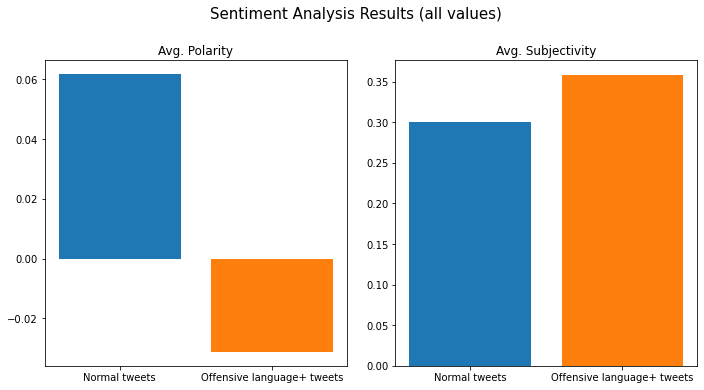

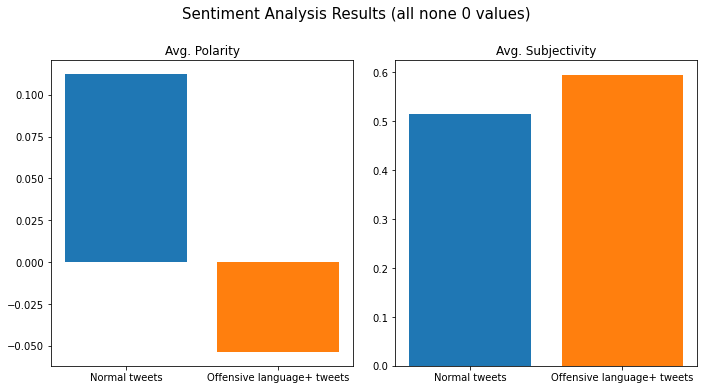

In [16]:
# All values
avg_polarity_normal_tweets = df[df["grouped_class_descr"] == "Normal"]["sentiment_polarity"].mean()
avg_polarity_off_tweets = df[df["grouped_class_descr"] == "Offensive language+"]["sentiment_polarity"].mean()
avg_subjectivity_normal_tweets = df[df["grouped_class_descr"] == "Normal"]["sentiment_subjectivity"].mean()
avg_subjectivity_off_tweets = df[df["grouped_class_descr"] == "Offensive language+"]["sentiment_subjectivity"].mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Sentiment Analysis Results (all values)", fontsize=15, y = 1.075)

axes[0].bar("Normal tweets", avg_polarity_normal_tweets)
axes[0].bar("Offensive language+ tweets", avg_polarity_off_tweets)
axes[0].title.set_text('Avg. Polarity')

axes[1].bar("Normal tweets", avg_subjectivity_normal_tweets)
axes[1].bar("Offensive language+ tweets", avg_subjectivity_off_tweets)
axes[1].title.set_text('Avg. Subjectivity')
fig.tight_layout()


# All none zero values
df_no_zero_polarity = df[~np.isclose(df['sentiment_polarity'], 0.0)]
df_no_zero_subjectivity = df[~np.isclose(df['sentiment_polarity'], 0.0)]

avg_polarity_normal_tweets = df_no_zero_polarity[df["grouped_class_descr"] == "Normal"]["sentiment_polarity"].mean()
avg_polarity_off_tweets = df_no_zero_polarity[df["grouped_class_descr"] == "Offensive language+"]["sentiment_polarity"].mean()
avg_subjectivity_normal_tweets = df_no_zero_subjectivity[df["grouped_class_descr"] == "Normal"]["sentiment_subjectivity"].mean()
avg_subjectivity_off_tweets = df_no_zero_subjectivity[df["grouped_class_descr"] == "Offensive language+"]["sentiment_subjectivity"].mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Sentiment Analysis Results (all none 0 values)", fontsize=15, y = 1.075)

axes[0].bar("Normal tweets", avg_polarity_normal_tweets)
axes[0].bar("Offensive language+ tweets", avg_polarity_off_tweets)
axes[0].title.set_text('Avg. Polarity')

axes[1].bar("Normal tweets", avg_subjectivity_normal_tweets)
axes[1].bar("Offensive language+ tweets", avg_subjectivity_off_tweets)
axes[1].title.set_text('Avg. Subjectivity')
fig.tight_layout()

It seems like the average sentiment polarity is clearly lower for offensive language+ tweets than for normal tweets. Therefore this will be a good feature for the machine learning models to work with. Meanwhile sentiment subjectivity does not make such a big difference in between normal tweets and tweets labeled as offensive language+

### 4.2 Text standard
I will use the ``textstat`` libraryto determine the textstandard for each tweet.

In [17]:
# quantify the text standard
def extract_textstandard_values(text):
    text = re.findall(r"-?\d{1,2}", text)
    return int(max(text))
    
df['text_standard']=df['tweet'].apply(lambda x: textstat.text_standard(x))
df["text_standard"] = df["text_standard"].apply(extract_textstandard_values)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text,sentiment_polarity,sentiment_subjectivity,text_standard
0,3,0,0,3,2,woman shouldnt complain cleaning house amp man...,Normal,0,"{'removed mentions': ['@mayasolovely'], 'remov...",0.000,0.000000,4
1,3,0,3,0,1,boy dat coldtyga dwn bad cuffin dat hoe st place,Offensive language+,1,"{'removed mentions': ['@mleew17'], 'removed ha...",-0.700,0.666667,4
2,3,0,3,0,1,dawg ever fuck bitch stato cry confuse shit,Offensive language+,1,"{'removed mentions': ['@urkindofbrand', '@80sb...",-0.300,0.700000,4
3,3,0,2,1,1,ganderson base look like tranny,Offensive language+,1,"{'removed mentions': ['@c', '@viva'], 'removed...",-0.800,1.000000,9
4,6,0,6,0,1,shit hear might true might faker bitch tell ya,Offensive language+,1,"{'removed mentions': ['@shenikaroberts'], 'rem...",0.075,0.725000,4


In [18]:
df[df["grouped_class_descr"] == "Normal"]["text_standard"].mean()

5.6331972135479225

In [19]:
df[df["grouped_class_descr"] == "Normal"]["text_standard"].median()

5.0

In [20]:
df[df["grouped_class_descr"] == "Offensive language+"]["text_standard"].mean()

4.052376333656644

In [21]:
df[df["grouped_class_descr"] == "Offensive language+"]["text_standard"].median()

4.0

It seems like there is a difference in text standard between normal and offensive language+ tweets. Offensive language+ tweets tend to have a slightly lower text standard than normal tweets. Therefore I will also use this feature in the machine learning models.

## 4. Creating equally sized dataframe with random sample
The original dataset has way more tweets labeled as "offensive language+" than tweets labeled as "Normal". Therefore in this step I am going to create an equally sized dataframe with an equal amount of normal and offensive language tweets by drawing a random sample from the offensive language tweets. 

In [22]:
# Creating Dataframe with random sample with 4163 Tweets with the label "Offensive language+"
df_off_lang_sample = df[df["grouped_class_descr"] == "Offensive language+"].sample(n = 4163, random_state = 2)

In [23]:
# creating Dataframe with all Tweets labeled as "Normal" (4163)
df_normal_sample = df[df["grouped_class_descr"] == "Normal"]

In [24]:
# Concatenating both Dataframes to one Dataframe
df_equal_size = pd.concat([df_off_lang_sample, df_normal_sample])

In [25]:
df_equal_size

,count,hate_speech,offensive_language,neither,class,tweet,grouped_class_descr,grouped_class,deleted_text,sentiment_polarity,sentiment_subjectivity,text_standard
4503,3,0,2,1,1,haha much pay constantly know youre talk dumb ...,Offensive language+,1,"{'removed mentions': ['@realskipbayless'], 're...",6.250000e-03,0.333333,6
14201,3,0,3,0,1,read lip bitch mouth isnt workin,Offensive language+,1,"{'removed mentions': ['@anotherpotheadd'], 're...",0.000000e+00,0.000000,3
20719,3,0,3,0,1,care tho appreciate laughing loud troll bitch ...,Offensive language+,1,"{'removed mentions': ['@jollymann'], 'removed ...",1.387779e-17,0.750000,8
9147,6,0,6,0,1,follow ah bitch ig tho inkkofrosess,Offensive language+,1,"{'removed mentions': [], 'removed hashtags': [...",0.000000e+00,0.000000,1
1030,3,0,3,0,1,vinchi bitch get bat sumn ak voice,Offensive language+,1,"{'removed mentions': ['@williebeaminn'], 'remo...",0.000000e+00,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...
24736,3,0,0,3,2,yaya ho cute avi tho ari idea sleep,Normal,0,"{'removed mentions': ['@vivala'], 'removed has...",5.000000e-01,1.000000,0
24737,3,0,1,2,2,yea tel new friend friends kno theyre allow on...,Normal,0,"{'removed mentions': ['@n'], 'removed hashtags...",2.590909e-01,0.588636,7
24767,3,0,1,2,2,know say early bird get worm put gummy worm mo...,Normal,0,"{'removed mentions': [], 'removed hashtags': [...",1.000000e-01,0.300000,5
24779,3,0,1,2,2,youve go break wrong heababy drive redneck crazy,Normal,0,"{'removed mentions': [], 'removed hashtags': [...",-5.500000e-01,0.900000,9


## 5. Creating word vectors & adding new features

### 5.1 Creating word vectors with countvectorizer and tfidfvectorizer

In [26]:
# Initializing different vectorizers
count_vectorizer = CountVectorizer()
tf_idf_vectorizer = TfidfVectorizer()

In [27]:
# Creating word vectors from features with the vectorizer above
x_features_CV =  count_vectorizer.fit_transform(df_equal_size['tweet']).toarray()
x_features_TFIDF =  tf_idf_vectorizer.fit_transform(df_equal_size['tweet']).toarray()

In [28]:
# Converting numpy array to Dataframe to look at the vectorized features
df_features_CV = pd.DataFrame(x_features_CV, columns=count_vectorizer.get_feature_names()).astype("int16")
df_features_TFIDF = pd.DataFrame(x_features_TFIDF, columns=tf_idf_vectorizer.get_feature_names()).astype("int16")

### 5.2 Filling all missing values with zero
In order for a machine learning model to work properly all missing values have to be replaced. In this case I choose the easiest version and simply replaced the missing values with 0.

In [29]:
df_features_CV.fillna(0, inplace = True)
df_features_TFIDF.fillna(0, inplace = True)

## 6. Training and evaluation of machine learning models
In this step I am going to train and evaluate the performance of the following machine learning models:
<br>
- Logistic Regression
- K-Neighbours Classifier
- Gaussian Naive Bayes
- Multinomial Naive Bayes
- Support Vector Machine
- Decision Tree
- Random Forrest
<br>
<br>

Each model will be evaluated with the following metrics:
- Accuracy
- Precision
- Recall
- F1-Score

Also each model will be trained and the performance will be evaluated based on two different datasets. The first dataset will have values based on the count vectorizer and the second dataset will have values based on the tfidf vectorizer.

### 6.1 Logistic Regression

#### 6.1.1 Count Vectorizer

In [31]:
Logistic_Regression_pipe = Pipeline([
    ("model", LogisticRegression())
])

Logistc_Regression_model = GridSearchCV(estimator = Logistic_Regression_pipe,
                                        n_jobs = -1,
                                        param_grid = {'model__warm_start': [False, True], 'model__solver': ['sag']},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)
                                                   },
                                        cv = 3,
                                        refit = "Accuracy")

Logistc_Regression_model.fit(df_features_CV, df_equal_size["grouped_class"])
#Logistic_Regression_pipe.get_params()

GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__solver': ['sag'],
                         'model__warm_start': [False, True]},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

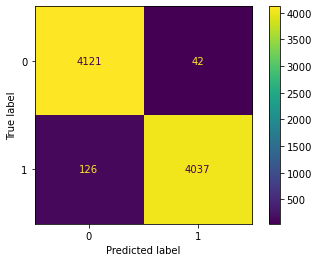

In [32]:
# Confusion matrix
y_pred = Logistc_Regression_model.best_estimator_.predict(df_features_CV)
y_true = df_equal_size["grouped_class"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot() 

In [33]:
pd.DataFrame(Logistc_Regression_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.943431,0.967590,0.91761,0.941934
1,0.943551,0.967832,0.91761,0.942049


#### 6.1.2 TFIDF Vectorizer

In [34]:
Logistic_Regression_pipe = Pipeline([
    ("model", LogisticRegression())
])

Logistc_Regression_model = GridSearchCV(estimator = Logistic_Regression_pipe,
                                        n_jobs = -1,
                                        param_grid = {'model__warm_start': [False, True], 'model__solver': ['sag']},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)
                                                   },
                                        cv = 3,
                                        refit = "Accuracy")

Logistc_Regression_model.fit(df_features_TFIDF, df_equal_size["grouped_class"])
#Logistic_Regression_pipe.get_params()

GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__solver': ['sag'],
                         'model__warm_start': [False, True]},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

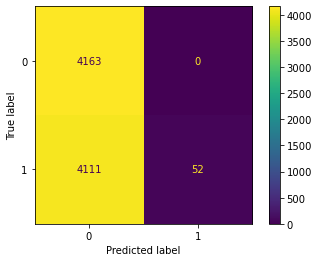

In [35]:
# Confusion matrix
y_pred = Logistc_Regression_model.best_estimator_.predict(df_features_TFIDF)
y_true = df_equal_size["grouped_class"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot() 

In [36]:
pd.DataFrame(Logistc_Regression_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.503003,0.807813,0.338859,0.233704
1,0.503003,0.807813,0.338859,0.233704


### 6.2 K-Neighbours Classifier

#### 6.2.1 Count Vectorizer

In [37]:

K_neighbours_pipe = Pipeline([
    ("model", KNeighborsClassifier())
])
#K_neighbours_pipe.get_params()


K_neighbours_model = GridSearchCV(estimator = K_neighbours_pipe,
                                       n_jobs = -1,
                                       param_grid = {'model__n_neighbors': list(range(1,6))},
                                       scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

K_neighbours_model.fit(df_features_CV, df_equal_size["grouped_class"])


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'model__n_neighbors': [1, 2, 3, 4, 5]},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [38]:
pd.DataFrame(K_neighbours_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.840504,0.795296,0.923851,0.853581
1,0.870170,0.859559,0.891903,0.873806
2,0.846750,0.800265,0.930579,0.859418
3,0.865727,0.837042,0.915445,0.873056
4,0.842068,0.792348,0.938265,0.857487


#### 6.2.2 TFIDF Vectorizer

In [39]:

K_neighbours_pipe = Pipeline([
    ("model", KNeighborsClassifier())
])
#K_neighbours_pipe.get_params()


K_neighbours_model = GridSearchCV(estimator = K_neighbours_pipe,
                                       n_jobs = -1,
                                       param_grid = {'model__n_neighbors': list(range(1,6))},
                                       scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

K_neighbours_model.fit(df_features_TFIDF, df_equal_size["grouped_class"])


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'model__n_neighbors': [1, 2, 3, 4, 5]},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [40]:
pd.DataFrame(K_neighbours_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.501921,0.641326,0.669308,0.450368
1,0.501921,0.641326,0.669308,0.450368
2,0.501801,0.500903,0.999760,0.667415
3,0.501801,0.500903,0.999760,0.667415
4,0.501801,0.500903,0.999760,0.667415


### 6.3 Gaussian Naive Bayes

#### 6.3.1 Count Vectorizer

In [41]:
Gaussian_NB_pipe = Pipeline([
    ("model", GaussianNB())
])
#Gaussian_NB_pipe.get_params()


Gaussian_NB_model = GridSearchCV(estimator = Gaussian_NB_pipe,
                                       n_jobs = -1,
                                       param_grid = {'verbose': [True, False]},
                                       scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

Gaussian_NB_model.fit(df_features_CV, df_equal_size["grouped_class"])

[Pipeline] ............. (step 1 of 1) Processing model, total=   2.2s


GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', GaussianNB())]),
             n_jobs=-1, param_grid={'verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [42]:
pd.DataFrame(Gaussian_NB_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.69121,0.648101,0.838337,0.730895
1,0.69121,0.648101,0.838337,0.730895


#### 6.3.2 TFIDF Vectorizer

In [43]:
Gaussian_NB_pipe = Pipeline([
    ("model", GaussianNB())
])
#Gaussian_NB_pipe.get_params()


Gaussian_NB_model = GridSearchCV(estimator = Gaussian_NB_pipe,
                                       n_jobs = -1,
                                       param_grid = {'verbose': [True, False]},
                                       scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

Gaussian_NB_model.fit(df_features_TFIDF, df_equal_size["grouped_class"])

[Pipeline] ............. (step 1 of 1) Processing model, total=   2.1s


GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', GaussianNB())]),
             n_jobs=-1, param_grid={'verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [44]:
pd.DataFrame(Gaussian_NB_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.501921,0.641326,0.669308,0.450368
1,0.501921,0.641326,0.669308,0.450368


### 6.4 Multinomial Naive Bayes
Multinomial Naive Bayes is only suitable for features with none negative values. Therefore it cant be used with the new feature "sentiment polarity" because this feature involves negative values. Multinomial Naive Bayes can only be used with no new features and without standard scaler because this also produces negative values.

#### 6.4.1 Count Vectorizer

In [45]:

Multinomial_NB_pipe = Pipeline([
    ("model", MultinomialNB())
])
#Multinomial_NB_pipe.get_params()


Multinomial_NB_model = GridSearchCV(estimator = Multinomial_NB_pipe,
                                       n_jobs = -1,
                                       param_grid = {'verbose': [True, False]},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

Multinomial_NB_model.fit(df_features_CV, df_equal_size["grouped_class"])


[Pipeline] ............. (step 1 of 1) Processing model, total=   2.1s


GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', MultinomialNB())]),
             n_jobs=-1, param_grid={'verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [46]:
pd.DataFrame(Multinomial_NB_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.909802,0.879632,0.950277,0.913431
1,0.909802,0.879632,0.950277,0.913431


#### 6.4.2 TFIDF Vectorizer

In [47]:

Multinomial_NB_pipe = Pipeline([
    ("model", MultinomialNB())
])
#Multinomial_NB_pipe.get_params()


Multinomial_NB_model = GridSearchCV(estimator = Multinomial_NB_pipe,
                                       n_jobs = -1,
                                       param_grid = {'verbose': [True, False]},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

Multinomial_NB_model.fit(df_features_TFIDF, df_equal_size["grouped_class"])


[Pipeline] ............. (step 1 of 1) Processing model, total=   2.0s


GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', MultinomialNB())]),
             n_jobs=-1, param_grid={'verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [48]:
pd.DataFrame(Multinomial_NB_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.504444,0.783181,0.342219,0.239871
1,0.504444,0.783181,0.342219,0.239871


### 6.5 Support Vector Machine

#### 6.5.1 Count Vectorizer

In [49]:

SVM_pipe = Pipeline([
    ("model", SVC())
])
#SVM_pipe.get_params()


SVM_model = GridSearchCV(estimator = SVM_pipe,
                                       n_jobs = -1,
                                       param_grid = {'model__verbose': [True, False]},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

SVM_model.fit(df_features_CV, df_equal_size["grouped_class"])


[LibSVM]

GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', SVC())]), n_jobs=-1,
             param_grid={'model__verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [50]:
pd.DataFrame(SVM_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.937185,0.978973,0.893588,0.934319
1,0.937185,0.978973,0.893588,0.934319


#### 6.5.2 TFIDF Vectorizer

In [51]:

SVM_pipe = Pipeline([
    ("model", SVC())
])
#SVM_pipe.get_params()


SVM_model = GridSearchCV(estimator = SVM_pipe,
                                       n_jobs = -1,
                                       param_grid = {'model__verbose': [True, False]},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

SVM_model.fit(df_features_TFIDF, df_equal_size["grouped_class"])


[LibSVM]

GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', SVC())]), n_jobs=-1,
             param_grid={'model__verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [52]:
pd.DataFrame(SVM_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.500121,0.62031,0.337898,0.233652
1,0.500121,0.62031,0.337898,0.233652


### 6.6 Decision Tree

#### 6.6.1 Count Vectorizer

In [53]:
Decision_Tree_pipe = Pipeline([
    ("model", DecisionTreeClassifier())
])
#Decision_Tree_pipe.get_params()


Decision_Tree_model = GridSearchCV(estimator = Decision_Tree_pipe,
                                       n_jobs = -1,
                                       param_grid = {'verbose': [True, False]},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

Decision_Tree_model.fit(df_features_CV, df_equal_size["grouped_class"])

[Pipeline] ............. (step 1 of 1) Processing model, total=  29.2s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model', DecisionTreeClassifier())]),
             n_jobs=-1, param_grid={'verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [54]:
pd.DataFrame(Decision_Tree_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.929019,0.928108,0.930339,0.929156
1,0.928778,0.926192,0.932020,0.929050


#### 6.6.2 TFIDF Vectorizer

In [55]:
Decision_Tree_pipe = Pipeline([
    ("model", DecisionTreeClassifier())
])
#Decision_Tree_pipe.get_params()


Decision_Tree_model = GridSearchCV(estimator = Decision_Tree_pipe,
                                       n_jobs = -1,
                                       param_grid = {'verbose': [True, False]},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

Decision_Tree_model.fit(df_features_TFIDF, df_equal_size["grouped_class"])

[Pipeline] ............. (step 1 of 1) Processing model, total=   0.6s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model', DecisionTreeClassifier())]),
             n_jobs=-1, param_grid={'verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [56]:
pd.DataFrame(Decision_Tree_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.503003,0.807813,0.338859,0.233704
1,0.503003,0.807813,0.338859,0.233704


### 6.7 Random Forrest

#### 6.7.1 Count Vectorizer

In [57]:
RF_pipe = Pipeline([
    ("model", RandomForestClassifier())
])
#RF_pipe.get_params()


RF_model = GridSearchCV(estimator = RF_pipe,
                                       n_jobs = -1,
                                       param_grid = {'verbose': [True, False]},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

RF_model.fit(df_features_CV, df_equal_size["grouped_class"])

[Pipeline] ............. (step 1 of 1) Processing model, total=  38.5s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model', RandomForestClassifier())]),
             n_jobs=-1, param_grid={'verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [58]:
pd.DataFrame(RF_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.938506,0.943083,0.933463,0.938218
1,0.937906,0.940922,0.934664,0.937743


#### 6.7.2 TFIDF Vectorizer

In [59]:
RF_pipe = Pipeline([
    ("model", RandomForestClassifier())
])
#RF_pipe.get_params()


RF_model = GridSearchCV(estimator = RF_pipe,
                                       n_jobs = -1,
                                       param_grid = {'verbose': [True, False]},
                                        scoring = {"presicion": make_scorer(precision_score), 
                                                   "recall": make_scorer(recall_score), 
                                                   "F1-Score": make_scorer(f1_score), 
                                                   "Accuracy": make_scorer(accuracy_score)},
                                        cv = 3,
                                        refit = "Accuracy")

RF_model.fit(df_features_TFIDF, df_equal_size["grouped_class"])

[Pipeline] ............. (step 1 of 1) Processing model, total=  17.5s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model', RandomForestClassifier())]),
             n_jobs=-1, param_grid={'verbose': [True, False]}, refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'F1-Score': make_scorer(f1_score),
                      'presicion': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [60]:
pd.DataFrame(RF_model.cv_results_)[[ "mean_test_Accuracy", "mean_test_presicion","mean_test_recall", "mean_test_F1-Score"]]

,mean_test_Accuracy,mean_test_presicion,mean_test_recall,mean_test_F1-Score
0,0.503003,0.807813,0.338859,0.233704
1,0.503003,0.807813,0.338859,0.233704
